<a href="https://colab.research.google.com/github/davidhinostroza/TFM_ChestX_Pneumonia/blob/master/TFM_Chest_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ![texto alternativo](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmBG5MR7QjdesSPQHy6nFwI7kKMBp6odP36zK1IdhoxEYyDa0) **TPU**







# Objetivo Proyecto TFM Deep Learning Rayos X del torax TPU.

Clasificar y detectar las enfermedades humanas a partir de las imagenes medicas de rayos X del torax como la Neumonia.
Para ello vamos a utilizar tecnologia google (unidad de procesamiento tensorial) TPU para comparar modelos binarios , Curvas Roc , matriz de confusión y comparar con un modelo pre-computado vs el modelo.



# Contexto

![texto alternativo](https://i.imgur.com/jZqpV51.png) 

### (imagen sustraida de Kaggle 


Tenemos images ilustrativos de radiografías de tórax en pacientes de neumonía. 
La radiografía de tórax normal (panel izquierdo) muestra los pulmones claros sin áreas opacas en la imagen del torax. 
La neumonía bacteriana (centro) exhibe una infección, en este caso en el lóbulo superior derecho (flechas blancas).
Mientras que la neumonía viral (derecha) se manifiesta con un patrón más difuso e "intersticial" en ambos pulmones.

Para ello construiremos un modelo de clasificación de imagen con Keras y tensorflow deep learning con tecnología TPU (unidad de procesamiento tensorial) donde utilizaremos modelo de tipo categórico con mediciones :


*   Matriz de confusión.
*   Curvas ROC AUC
*   Curvas ROC RECALL

Y se compara una red pre-computada para clasificación de imagen vs el modelo. 

# **Datos y Clasificación**

El conjunto de datos está organizado en 3 carpetas (train, test, val) y contiene subcarpetas para cada categoría de imagen (Pneumonia / Normal). 

Hay 5.863 imágenes de rayos X (JPEG) y 2 categorías (neumonía / normal).
Antes de cargar las imagenes tendre que etiquetarlas de la siguiente manera :							
- Tórax normal      = 0	
- Tórax Neumonia = 1

Fuente de datos : 

http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

# **Arquitectura**


*   Google Colab Free TPU
*   Google Colab Free GPU
*   Python
*   Pandas
*   Keras



# Instalación del entorno


In [1]:
!pip install keras


# Datos guardados en Google Drive

Para ello es necesario darle click al enlace donde obtendrás un token de seguridad al ejecutarse la linea posterior.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# Descompresión de las carpetas

In [4]:
# Borrado de carpetas (Si es que existieran)

!rm -f t*.zip
!rm -f -r dog*
!rm -f -r ches*
!ls -hl

# Download a file based on its file ID.
#

file_id = '1QXMJH_H3T-GdCA4CvReNbP7UdRw7OpnV'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("train.zip")

file_id = '1X0Ux_dC7OlNLBH50gFTkMZ_Wl1hJ4RaJ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("test.zip")

file_id = '1Xi9wcxrSwKa0jIh9XsNungBWHSCdxMOF'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("val.zip")


total 8.0K
-rw-r--r-- 1 root root 2.6K Jan 18 16:49 adc.json
drwxr-xr-x 1 root root 4.0K Jan  8 17:15 sample_data


In [0]:
#Creación y descompresión de las carpetas.
!mkdir chestX
!cd chestX && unzip -q ../train.zip
!cd chestX && unzip -q ../test.zip
!cd chestX && unzip -q ../val.zip


In [156]:
#Listado de la carpeta train
!ls ./chestX/train


NORMAL	PNEUMONIA


# Librerías a utilizar

In [0]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,MaxPooling2D,Conv2D,Flatten,Dropout,MaxPool2D,Softmax,Input,ELU
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.layers.merge import add
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,classification_report, confusion_matrix
from tqdm import tqdm  
import cv2   
import scipy
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt
import h5py
import os, shutil
import glob
import time
import random
from tensorflow import set_random_seed

# Exploración de Imágenes

In [0]:
import cv2
total_images_train_normal = os.listdir('../content/chestX/train/NORMAL/')
total_images_train_pneumonia = os.listdir('../content/chestX/train/PNEUMONIA/')

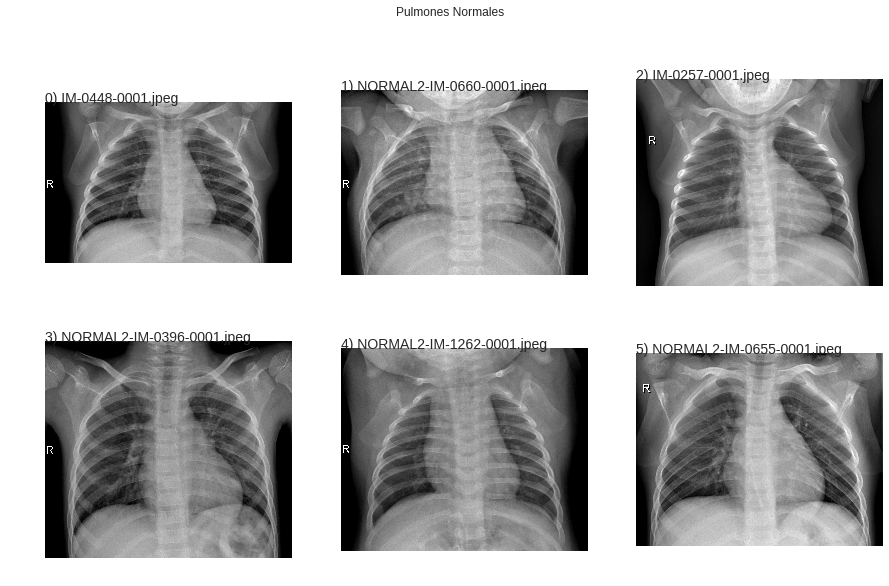

In [176]:
sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))
for i in range(0,6):
    filename=sample_normal[i]
    im = cv2.imread('../content/chestX/train/NORMAL/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
    ax[i//3,i%3].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Pulmones Normales')
plt.show()

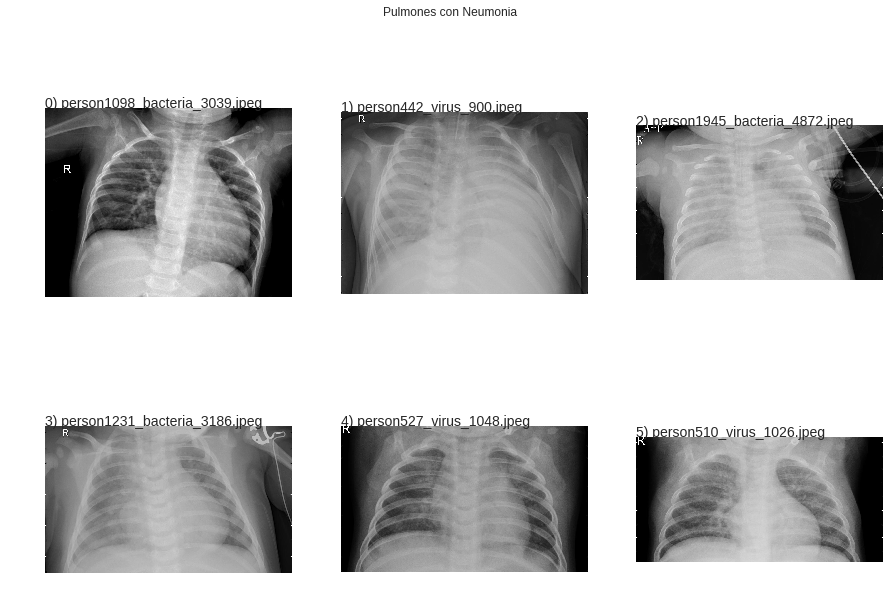

In [189]:
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,10))

for i in range(0,6):
    filename=sample_pneumonia[i]
    im = cv2.imread('../content/chestX/train/PNEUMONIA/'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
    ax[i//3,i%3].text(0.1, 0.9, str(i)+') ' + filename, fontsize=14)
f.suptitle('Pulmones con Neumonia')
plt.show()

1349
3884


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


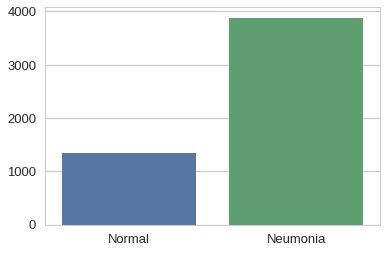

In [195]:
import seaborn as sns
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Neumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])
print(len(total_images_train_normal))
print(len(total_images_train_pneumonia))

# Configuración de las imágenes

In [0]:
#os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
set_random_seed(1)

In [53]:
from tensorflow.keras import backend as K

img_width, img_height = 64, 64

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
input_shape

(64, 64, 1)

# Crear modelo TPU de clasificación

In [89]:
model=tf.keras.models.Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))


model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation('softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 64)        0         
__________

# Generación de lotes de imágenes


Generar lotes de datos tensor de imágenes con aumento de datos en tiempo real. Los datos se pasarán (en lotes).

In [0]:
TRAIN_DIR = "../content/chestX/train/"
TEST_DIR =  "../content/chestX/test/"
VALID_DIR=  "../content/chestX/val/"

In [0]:
#Generadores Genericos que cojan las imagenes del disco
from keras.preprocessing import image
train_datagen=image.ImageDataGenerator(rescale=1./255.0, shear_range=0.2,zoom_range=0.2, horizontal_flip=True)
validation_datagen=image.ImageDataGenerator(rescale=1./255.0)
test_datagen=image.ImageDataGenerator(rescale=1./255.0)

In [92]:
#Generadores Genericos que cojan las imagenes del disco
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from keras.metrics import categorical_accuracy
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_batches = gen.flow_from_directory("../content/chestX/train/",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)
valid_batches = gen.flow_from_directory("../content/chestX/val/", model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)
test_batches = gen.flow_from_directory("../content/chestX/test/", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=16)

Found 5232 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Compilación y ejecución del modelo

In [125]:
import os
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0001),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)


history=tpu_model.fit_generator(train_batches,validation_data=test_batches,epochs=30, steps_per_epoch=100, validation_steps=20)


INFO:tensorflow:Querying Tensorflow master (b'grpc://10.13.13.202:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8991422930431371358)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16755881369817656890)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 14994948846257905735)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16595362293894248093)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 5371215074539648949)
INFO:tensorflow:*** Available Device: _Devic

# Predecir el modelo con los datos de test

Convertimos los datos predecidos a un dataFrame y calculamos la precisión de un 85%.

In [126]:
no_steps = len(test_batches)
p = tpu_model.predict_generator(test_batches, verbose=True)
pre = pd.DataFrame(p)
pre['item']=pre.reset_index().index
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)
accuracy_score(pre["label"], pre["pre"])

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(2, 64, 64, 1), dtype=tf.float32, name='batch_normalization_6_input_20')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_6_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.242609977722168 secs
39/39 [==============================] - 9s 218ms/step


0.8541666666666666

# Función para pintar las metricas.

In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

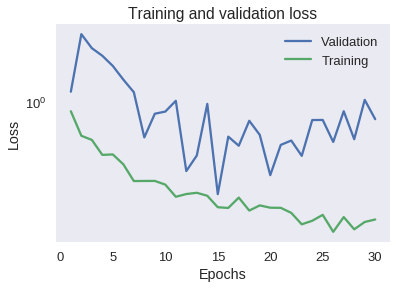

In [129]:
plot_metric(history,'loss')

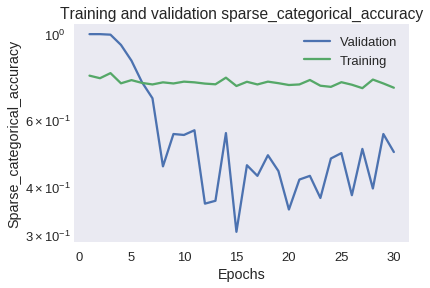

In [130]:
plot_metric(history,'sparse_categorical_accuracy')

# Listado de las 20 primeras predicciones guardadas en el dataFrame.

In [131]:
pre[:20]


,0,1,item,filename,label,pre
0,0.991643,0.008357,0,NORMAL/IM-0001-0001.jpeg,0,0
1,0.916427,0.083573,1,NORMAL/IM-0003-0001.jpeg,0,0
2,0.868494,0.131506,2,NORMAL/IM-0005-0001.jpeg,0,0
3,0.561022,0.438978,3,NORMAL/IM-0006-0001.jpeg,0,0
4,0.993883,0.006117,4,NORMAL/IM-0007-0001.jpeg,0,0
5,0.999350,0.000650,5,NORMAL/IM-0009-0001.jpeg,0,0
6,0.996148,0.003852,6,NORMAL/IM-0010-0001.jpeg,0,0
7,0.973596,0.026404,7,NORMAL/IM-0011-0001-0001.jpeg,0,0
8,0.845622,0.154378,8,NORMAL/IM-0011-0001-0002.jpeg,0,0
9,0.987439,0.012561,9,NORMAL/IM-0011-0001.jpeg,0,0


# Visualización de una predicción Erronea ( Registro 16)

Es un pulmón normal pero se predice con Neumonia.

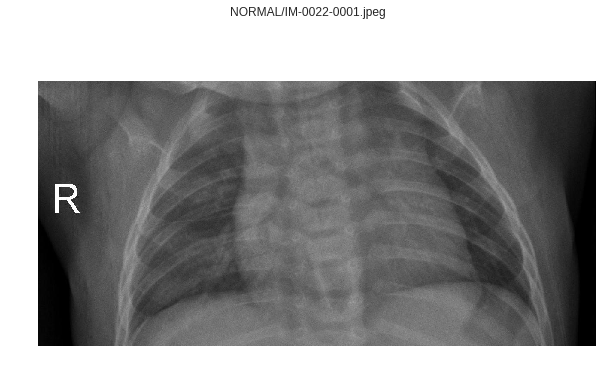

In [132]:
N=16
pre["filename"][N]
import cv2
f,ax = plt.subplots(1,1,figsize=(10,6))
im = cv2.imread('../content/chestX/test/'+pre["filename"][N])
ax.imshow(im)
ax.axis('off')
f.suptitle(pre["filename"][N])
plt.show()

# Mostrar la matriz de predicción

[[160  74]
 [ 17 373]]


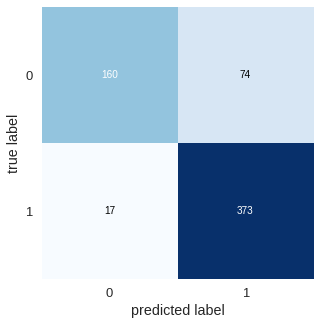

In [133]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(pre["label"], pre["pre"])
print(CM)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

# Calcular la precisión y Recall.

Vemos que tenemos una precisión del 83% y un recall del 96 % (TP /TP + FN)

In [134]:
# Calculate Precision and Recall
tn, fp, fn, tp = CM.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.96
Precision of the model is 0.83


In [135]:
accuracy_score(pre["label"], pre["pre"])

0.8541666666666666

# Array de predicciones erróneas

In [0]:
wrong=np.where(pre['pre']!=pre['label'])[0]

In [137]:
wrong
#

array([ 11,  14,  16,  20,  24,  26,  31,  34,  44,  47,  52,  56,  61,
        62,  67,  83,  89,  97, 109, 113, 117, 118, 119, 120, 121, 122,
       123, 124, 126, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 153, 160, 166, 167, 168,
       171, 172, 174, 178, 183, 186, 193, 195, 198, 200, 204, 215, 216,
       217, 218, 219, 222, 226, 227, 228, 230, 233, 282, 317, 388, 390,
       391, 405, 473, 479, 494, 496, 498, 503, 519, 529, 599, 601, 623])

In [138]:
len(wrong)

91

In [0]:
#df_wrong=pre.loc[pre.item.isin(wrong)]

In [141]:
target_names = ['Normal', 'Pneumonia']
print(classification_report(pre["label"], pre["pre"], target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.90      0.68      0.78       234
   Pneumonia       0.83      0.96      0.89       390

   micro avg       0.85      0.85      0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



In [143]:
# Evaluate the model on test set
score = tpu_model.evaluate(test_batches, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7163461538461539


# Visualizar al azar las predicciones del modelo.


    item                               filename         0         1  label  pre
0    413   PNEUMONIA/person1618_virus_2805.jpeg  0.001207  0.998793      1    1
1    397  PNEUMONIA/person157_bacteria_740.jpeg  0.000161  0.999839      1    1
2    344  PNEUMONIA/person136_bacteria_652.jpeg  0.000058  0.999942      1    1
3    573   PNEUMONIA/person81_bacteria_395.jpeg  0.001519  0.998481      1    1
4    414   PNEUMONIA/person1619_virus_2806.jpeg  0.170401  0.829599      1    1
5    417  PNEUMONIA/person161_bacteria_762.jpeg  0.003175  0.996825      1    1
6    155       NORMAL/NORMAL2-IM-0279-0001.jpeg  0.999779  0.000221      0    0
7     13               NORMAL/IM-0017-0001.jpeg  0.993523  0.006477      0    0
8    108       NORMAL/NORMAL2-IM-0131-0001.jpeg  0.999036  0.000964      0    0
9    264       PNEUMONIA/person10_virus_35.jpeg  0.015116  0.984884      1    1
10   199       NORMAL/NORMAL2-IM-0337-0001.jpeg  0.999422  0.000578      0    0
11   272  PNEUMONIA/person112_bacteria_5

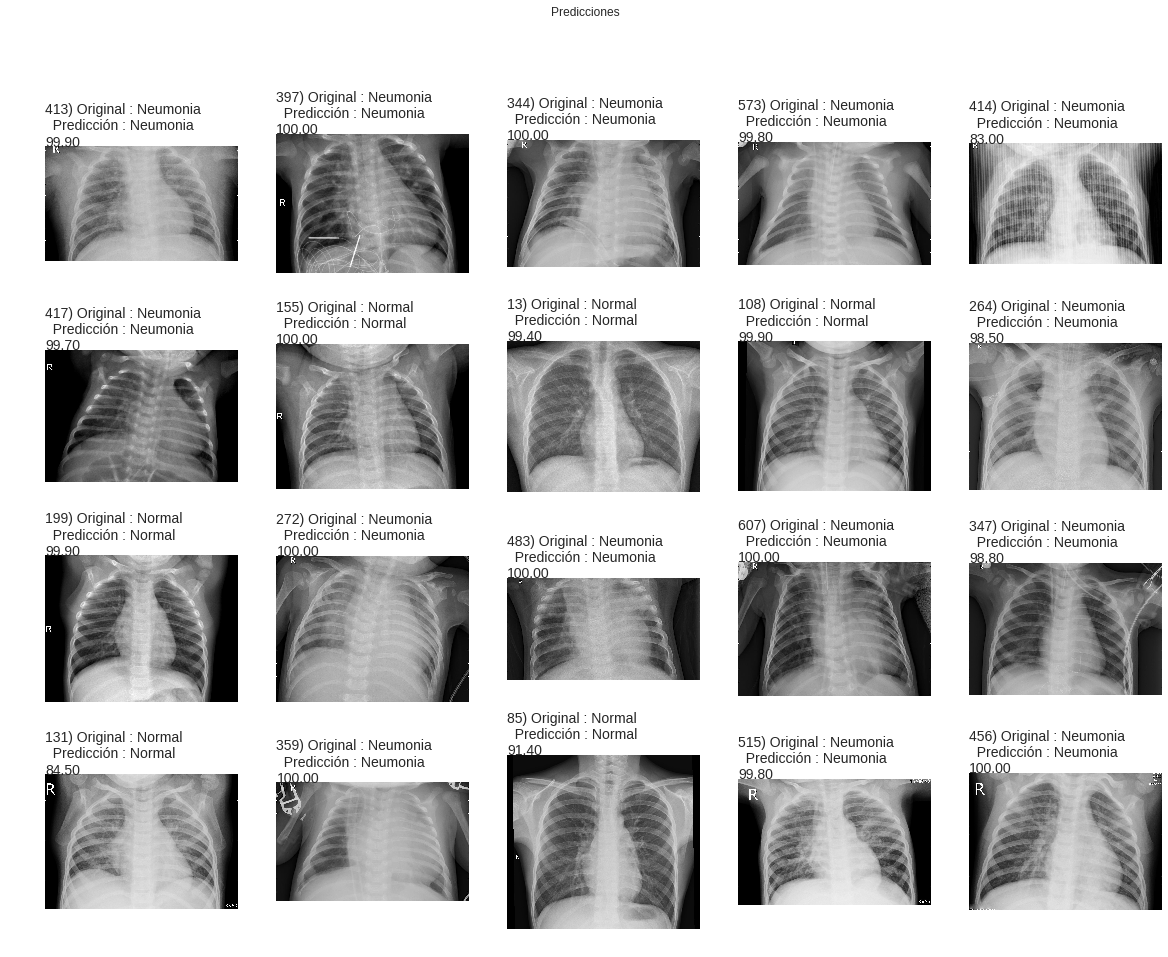

In [196]:
num=20
LABEL_NAMES = ['Normal', 'Neumonia']
#sample_pneumonia = random.sample(list(pre["filename"]),6)
df = pd.DataFrame(random.sample(list(pre['item']),num),columns = ["item"])
sample_pneumonia = pd.merge(df,pre[['item','filename',0,1,'label','pre']],on='item')#.sort_index('item')
sample_pneumonia[:20]
pd.set_option('display.expand_frame_repr', False)
print(sample_pneumonia)
f,ax = plt.subplots(4,5,figsize=(20,15))
for i in range(0,num):
    im = cv2.imread('../content/chestX/test/'+sample_pneumonia['filename'][i])
    #print(im)
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
    prediction=sample_pneumonia['pre'][i]
    label = LABEL_NAMES[sample_pneumonia['label'][i]]
    label_predict = LABEL_NAMES[sample_pneumonia['pre'][i]]
    confidence = round(sample_pneumonia[prediction][i]*100,1)
    item= sample_pneumonia['item'][i]
    ax[i//5,i%5].text(0.4, 0.4, str(item)+') ' + 'Original : ' +label + '\n' +'  Predicción : ' +label_predict + '\n%.2f' % confidence, fontsize=14)
f.suptitle('Predicciones')
 
plt.show()

# Visualizar al azar las predicciones Erroneas del modelo.

    item                               filename         0         1  label  pre
0     16               NORMAL/IM-0022-0001.jpeg  0.000327  0.999673      0    1
1    133       NORMAL/NORMAL2-IM-0232-0001.jpeg  0.000949  0.999052      0    1
2    132       NORMAL/NORMAL2-IM-0229-0001.jpeg  0.171535  0.828465      0    1
3    183       NORMAL/NORMAL2-IM-0317-0001.jpeg  0.471422  0.528578      0    1
4    172       NORMAL/NORMAL2-IM-0303-0001.jpeg  0.293611  0.706389      0    1
5    153       NORMAL/NORMAL2-IM-0277-0001.jpeg  0.011076  0.988924      0    1
6    233       NORMAL/NORMAL2-IM-0381-0001.jpeg  0.014079  0.985921      0    1
7    227  NORMAL/NORMAL2-IM-0374-0001-0001.jpeg  0.232559  0.767441      0    1
8     89       NORMAL/NORMAL2-IM-0073-0001.jpeg  0.020881  0.979119      0    1
9    174       NORMAL/NORMAL2-IM-0305-0001.jpeg  0.491208  0.508792      0    1
10   228  NORMAL/NORMAL2-IM-0374-0001-0002.jpeg  0.192477  0.807523      0    1
11    56               NORMAL/IM-0091-00

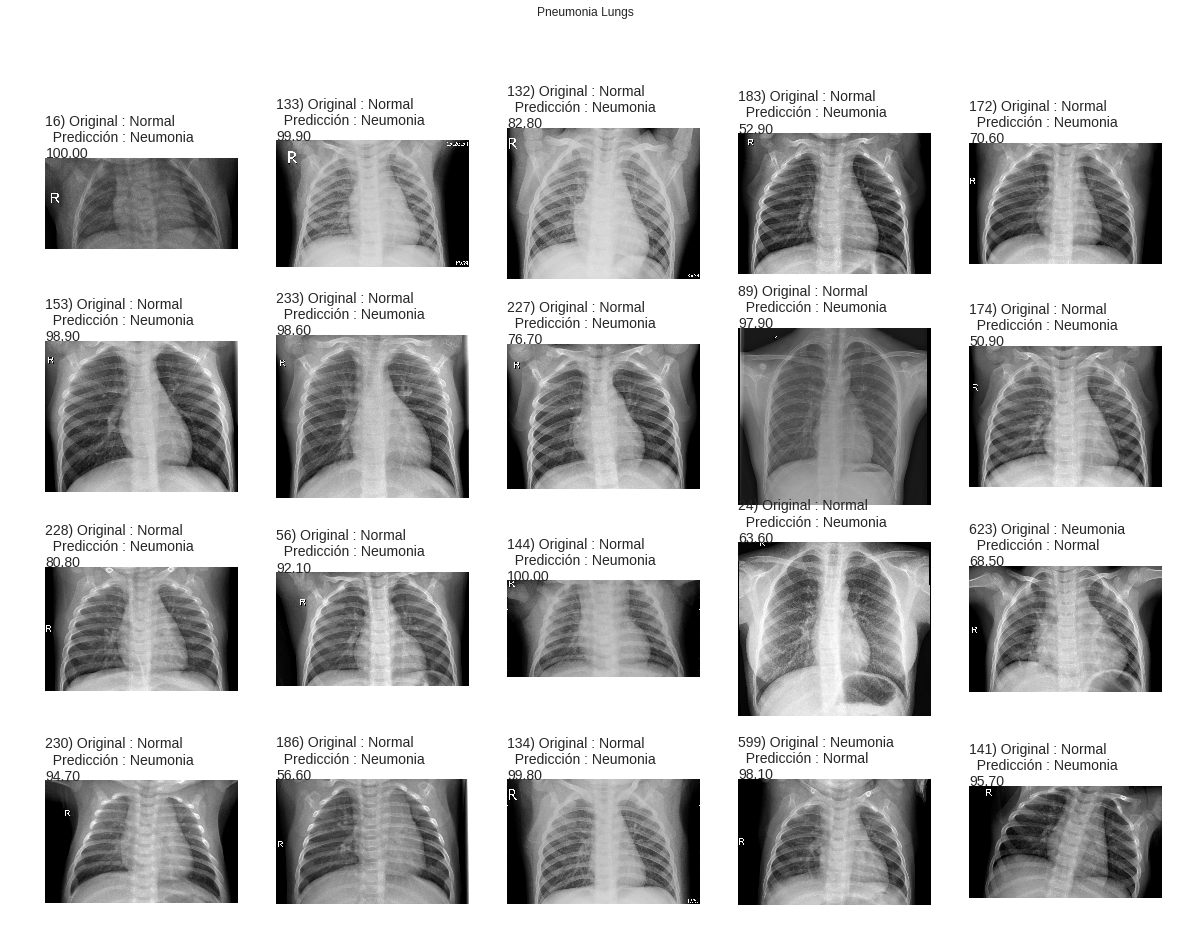

In [197]:
num=20
LABEL_NAMES = ['Normal', 'Neumonia']
df = pd.DataFrame(random.sample(list(pre.loc[pre.item.isin(wrong)]['item']),num),columns = ["item"])
sample_pneumonia = pd.merge(df,pre[['item','filename',0,1,'label','pre']],on='item')#.sort_index('item')
pd.set_option('display.expand_frame_repr', False)
print(sample_pneumonia)
f,ax = plt.subplots(4,5,figsize=(20,15))
for i in range(0,num):
    im = cv2.imread('../content/chestX/test/'+sample_pneumonia['filename'][i])
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
    prediction=sample_pneumonia['pre'][i]
    label = LABEL_NAMES[sample_pneumonia['label'][i]]
    label_predict = LABEL_NAMES[sample_pneumonia['pre'][i]]
    confidence = round(sample_pneumonia[prediction][i]*100,1)
    item= sample_pneumonia['item'][i]
    ax[i//5,i%5].text(0.4, 0.4, str(item)+') ' + 'Original : ' +label + '\n' +'  Predicción : ' +label_predict + '\n%.2f' % confidence, fontsize=14)
f.suptitle('Predicciones Erroneas')
 
plt.show()

# Calculo de metricas

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

from matplotlib import pyplot

# El área bajo la curva ROC (AUC)

In [0]:
# calculate AUC
auc = roc_auc_score(pre["label"], pre["pre"])

In [149]:
print('AUC: %.3f' % auc)

AUC: 0.820


In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(pre["label"], pre["pre"])

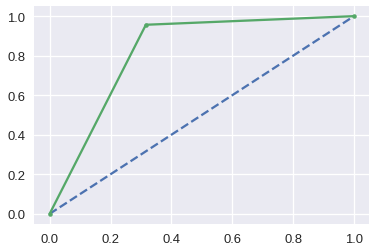

In [151]:
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

## **RECALL ROC**

In [0]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(pre["label"], pre["pre"])

f1=0.891 auc=0.820 ap=0.825


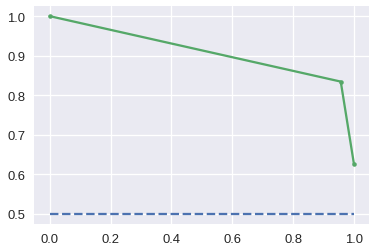

In [153]:

# calculate F1 score
#
f1 = f1_score( pre["label"], pre["pre"])
# calculate average precision score
ap = average_precision_score(pre["label"], pre["pre"])
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

Para este modelo vamos a utilizar la sensibilidad (Recall) para encontrar los verdaderos positivos que esta al 96%.